In [12]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import theano.tensor as tt
from kl import KullbackLiebler

In [2]:
az.style.use('arviz-darkgrid')

In [6]:
dim = 4

W0 = 0.9
W1 = 1-W0
MEAN0 = -0.5
MEAN1 = 0.5

In [7]:
mu0 = np.ones(dim) * MEAN0
mu1 = np.ones(dim) * MEAN1

stdev = 0.1
sigma = np.power(stdev, 2) * np.eye(dim)
isigma = np.linalg.inv(sigma)
dsigma = np.linalg.det(sigma)


def two_gaussians(x):
    log_like1 = - 0.5 * dim * tt.log(2 * np.pi) \
                - 0.5 * tt.log(dsigma) \
                - 0.5 * (x - mu0).T.dot(isigma).dot(x - mu0)
    log_like2 = - 0.5 * dim * tt.log(2 * np.pi) \
                - 0.5 * tt.log(dsigma) \
                - 0.5 * (x - mu1).T.dot(isigma).dot(x - mu1)
    return pm.math.logsumexp([tt.log(W0) + log_like1, tt.log(W1) + log_like2])

In [8]:
with pm.Model() as model:
    X = pm.Uniform('X',
                   shape=dim,
                   lower=-2. * np.ones_like(mu1),
                   upper=2. * np.ones_like(mu1),
                   testval=-1. * np.ones_like(mu1))
    llk = pm.Potential('llk', two_gaussians(X))
    trace = pm.sample_smc(2000, parallel=True, cores=4, p_acc_rate=0.95)
    idata = az.from_pymc3(trace=trace)

Initializing SMC sampler...
Sampling 4 chains in 4 jobs
/home/osvaldo/anaconda3/envs/bmcp/lib/python3.9/site-packages/pymc3/sampling.py:1925: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  warnings.warn(
/home/osvaldo/anaconda3/envs/bmcp/lib/python3.9/site-packages/pymc3/sampling.py:1925: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  warnings.warn(
/home/osvaldo/anaconda3/envs/bmcp/lib/python3.9/site-packages/pymc3/sampling.py:1925: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  warnings.warn(
/home/osvaldo/anaconda3/envs/bmcp/lib/python3.9/site-packages/pymc3/sampling.py:1925: UserWarning: The effect of Potentials on other p

KeyboardInterrupt: 

  File "/home/osvaldo/anaconda3/envs/bmcp/lib/python3.9/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
KeyboardInterrupt
  File "/home/osvaldo/anaconda3/envs/bmcp/lib/python3.9/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/home/osvaldo/anaconda3/envs/bmcp/lib/python3.9/site-packages/theano/compile/function/types.py", line 974, in __call__
    self.fn()
  File "/home/osvaldo/anaconda3/envs/bmcp/lib/python3.9/site-packages/pymc3/smc/smc.py", line 235, in mutate
    pl = np.array([self.prior_logp_func(prop) for prop in proposal])
  File "/home/osvaldo/anaconda3/envs/bmcp/lib/python3.9/multiprocessing/pool.py", line 51, in starmapstar
    return list(itertools.starmap(args[0], args[1]))
  File "/home/osvaldo/anaconda3/envs/bmcp/lib/python3.9/site-packages/pymc3/smc/sample_smc.py", line 276, in sample_smc_int
    smc.mutate()
KeyboardInterrupt
  File "/home/osvaldo/anaconda3/envs/bmcp/lib/python3.9/mul

In [ ]:
az.plot_trace(idata, kind="rank_vlines");

In [ ]:
az.summary(idata)

# Compute KL divergence

In [ ]:
posterior = idata.posterior
n_chains = posterior.chain
chains_flat = posterior["X"].stack(samples=("draw", "chain", "X_dim_0")).values
chains = posterior["X"].stack(samples=("draw", "X_dim_0"))

In [ ]:
lala = KullbackLiebler(chains_flat)
KL_list = [lala(chains[idx].values) for idx in n_chains]
np.mean(KL_list), np.std(KL_list)

# Compute error score

In [ ]:
# Wang bimodality index True Value
BI = abs(MEAN0 - MEAN1) * (W0*(1-W0))**0.5

error_score_list = []

for chain in posterior["chain"]:
    for dimension in posterior["X_dim_0"]:
        v = np.ravel(posterior.isel(chain=chain, X_dim_0=dimension)["X"])
        above_zero = v > 0
        below_zero = v < 0
        w0_ = np.mean(below_zero)
        if np.any(above_zero) and np.any(below_zero):
            BI_ = abs(v[below_zero].mean() - v[above_zero].mean()) * (w0_*(1-w0_))**0.5
        else:
            BI_ = 0
        error_score = (np.mean(((v-MEAN0) * W0 + (v-MEAN1) * W1))**2)**0.5 + abs(BI - BI_)
        error_score_list.append(error_score)

np.mean(error_score_list), np.std(error_score_list)

# Hierarchical Model

For this model we may use NUTS as a "gold-standard"

In [14]:
data = pd.read_csv('radon.csv')

county_names = data.county.unique()
county_idx = data['county_code'].values.astype(np.int32)
n_counties = len(data.county.unique())

In [29]:
with pm.Model() as hierarchical_model_non_centered:
    mu_a = pm.Normal('mu_a', mu=0., sd=5)
    sigma_a = pm.HalfNormal('sigma_a', 5)
    mu_b = pm.Normal('mu_b', mu=0., sd=5)
    sigma_b = pm.HalfNormal('sigma_b', 5)
    a_offset = pm.Normal('a_offset', mu=0, sd=2, shape=n_counties)
    a = pm.Deterministic("a", mu_a + a_offset * sigma_a)
    b_offset = pm.Normal('b_offset', mu=0, sd=2, shape=n_counties)
    b = pm.Deterministic("b", mu_b + b_offset * sigma_b)
    eps = pm.HalfNormal('eps', 5)
    radon_est = a[county_idx] + b[county_idx] * data.floor.values
    radon_like = pm.Normal('radon_like', mu=radon_est, sd=eps, observed=data.log_radon)
    idata_nuts = pm.sample(2000, tune=2000, chains=4, target_accept=0.9, return_inferencedata=True)
    trace = pm.sample_smc(2000, chains=4, parallel=True, p_acc_rate=0.95)
    idata_smc = az.from_pymc3(trace)

Initializing SMC sampler...
Sampling 4 chains in 2 jobs
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.002
Stage:   2 Beta: 0.004
Stage:   3 Beta: 0.006
Stage:   4 Beta: 0.008
Stage:   5 Beta: 0.011
Stage:   6 Beta: 0.016
Stage:   7 Beta: 0.024
Stage:   8 Beta: 0.039
Stage:   9 Beta: 0.066
Stage:  10 Beta: 0.111
Stage:  11 Beta: 0.168
Stage:  12 Beta: 0.234
Stage:  13 Beta: 0.301
Stage:  14 Beta: 0.372
Stage:  15 Beta: 0.447
Stage:  16 Beta: 0.533
Stage:  17 Beta: 0.628
Stage:  18 Beta: 0.731
Stage:  19 Beta: 0.839
Stage:  20 Beta: 0.952
Stage:  21 Beta: 1.000


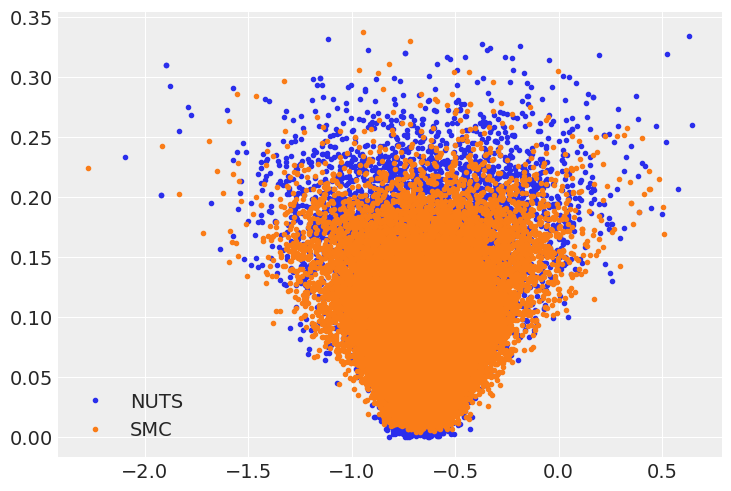

In [30]:
nuts_posterior = idata_nuts.posterior.stack(samples=("chain", "draw"))
smc_posterior = idata_smc.posterior.stack(samples=("chain", "draw"))
plt.plot(nuts_posterior["b"].isel(b_dim_0=75), nuts_posterior["sigma_b"], '.C0', label="NUTS")
plt.plot(smc_posterior["b"].isel(b_dim_0=75), smc_posterior["sigma_b"], '.C1', label="SMC")

plt.legend();